In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio, phys_grad, compute_core_mean

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)


In [4]:
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies['TiltDis_diff'] = df_eddies.groupby('Eddy').TiltDis.diff()
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,Rc,psi0,A,R,Age,Date,fname,TiltDis,TiltDir,TiltDis_diff
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110,NaN
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602,1.930778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,11.563679,343.688930,1.507853
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803,1.284446
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN


In [5]:
num_profiles = len(df_eddies)-6*len(df_eddies.Eddy.unique())
print(f'Total No. of used profiles: {num_profiles}')
num_tilt_profiles = np.sum(~np.isnan(df_eddies.TiltDis))
print(f'Total No. of profiles tilt measured: {num_tilt_profiles}')
print(f'Tilt measuring success rate: {num_tilt_profiles/num_profiles*100:.2f}%')


Total No. of used profiles: 89452
Total No. of profiles tilt measured: 66721
Tilt measuring success rate: 74.59%


In [6]:
df_tilt_data_clean = df_tilt_data.dropna().copy()
percent_prof_TD_blw_40 = np.sum(df_tilt_data_clean.TiltDis <= 40) / num_tilt_profiles
print(f'% Profiles below 40km TD: {percent_prof_TD_blw_40*100:.2f}%')
print(f'Max TD {df_tilt_data_clean.TiltDis.max():.0f}')


% Profiles below 40km TD: 85.83%
Max TD 149


In [7]:
# sample tilt sanity check
queries = {
    66: 26,
    425: 17,
    871: 5,
    1780: 51,
    31: 68,
    182: 89,
    1602: 114,
    2128: 40
}
rows = []
for eddy, offset in queries.items():
    df_eddy = df_eddies[df_eddies.Eddy == eddy]
    target_day = df_eddy.Day.iloc[0] + offset
    df_row = df_eddy[df_eddy.Day == target_day][["Eddy","TiltDis","TiltDir"]]
    rows.append(df_row)
df_print = pd.concat(rows)
df_print


,Eddy,TiltDis,TiltDir
2948,66,33.102737,345.187597
17380,425,5.543649,359.981910
35345,871,11.654502,325.108842
71635,1780,19.476659,36.319065
1311,31,NaN,NaN
7743,182,18.527909,132.390564
64574,1602,6.619274,168.142872
85942,2128,10.491482,244.676908


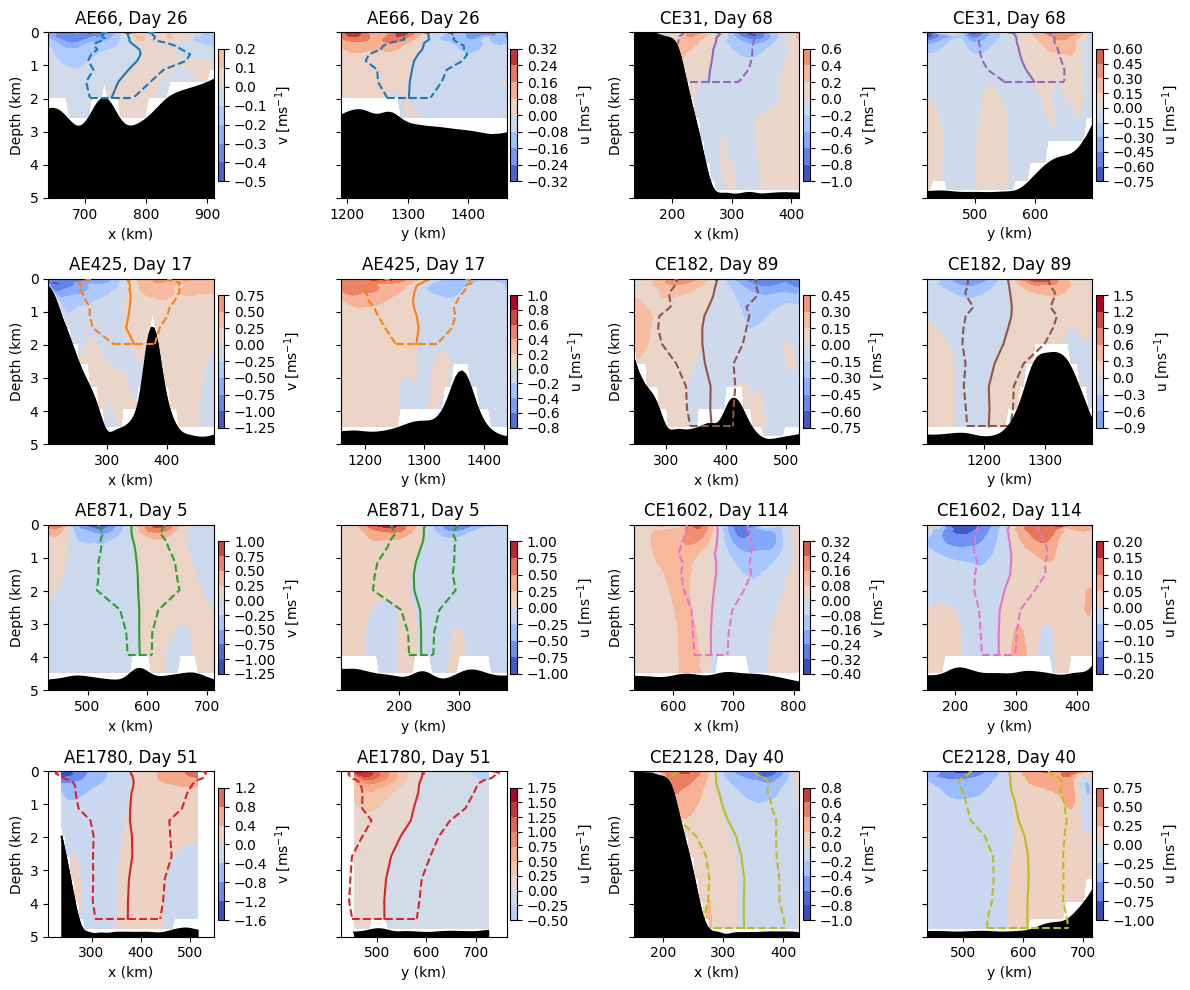


#### Additional Data

In [8]:
# Lifespan Day Index
day_idxs = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    if len(df):
        day_idxs.extend(df.Day-df.Day.iloc[0])
df_eddies['Day_idx'] = day_idxs

# Dimensionless Time
norm_time = []
for eddy in df_eddies.Eddy.unique():
    seg = df_eddies[df_eddies.Eddy == eddy]
    n = len(seg)
    norm_time.extend(np.arange(n) / n)
df_eddies['norm_time'] = norm_time

# Aspect Ratio
ARs = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    ARs.append(ellipse_aspect_ratio(data.q11, data.q12, data.q22))
df_eddies['AR'] = ARs

# Batheymetry averaged about the core
df_eddies = compute_core_mean(
    df_eddies,
    X_grid, Y_grid,
    mask_rho,
    fixed_field=h,
    colname="h"
)
# df_eddies['h'] = h[df_eddies.ic, df_eddies.jc]

# Coriolis
f = np.transpose(dataset.variables['f'], axes=(1, 0))
df_eddies['f'] = f[df_eddies.ic, df_eddies.jc]

# Rossby Number
df_eddies['Ro'] = df_eddies.w / df_eddies.f

# Potential Vorticity
df_eddies['PV'] = (df_eddies.w + df_eddies.f) / df_eddies.h

# Nbar
df_eddies = compute_core_mean(
    df_eddies,
    X_grid, Y_grid,
    mask_rho,
    base_path="/srv/scratch/z5297792/Climatology/N2s/Nbars_300m_depth",
    varname="Nbar",
    colname="Nbar"
)

# Slope Magntiude
dhdx, dhdy = phys_grad(h, X_grid*1e3, Y_grid*1e3, mask_rho)    # IS W.R.T THE GRID !!!!
s = np.hypot(dhdx, dhdy)
df_eddies['s'] = s[df_eddies.ic, df_eddies.jc]

# AE CE DataFrames
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()
df_AE_ = df_eddies[df_eddies.Cyc=='AE'].copy()
df_AE_ = df_AE_[~df_AE_.TiltDis.isna()]
df_CE_ = df_eddies[df_eddies.Cyc=='CE'].copy()
df_CE_ = df_CE_[~df_CE_.TiltDis.isna()]

print(f'AE TD Mean: {round(df_AE.TiltDis.mean())}km')
print(f'CE TD Mean: {round(df_CE.TiltDis.mean())}km')


AE TD Mean: 23km
CE TD Mean: 20km


### Latitude Analysis

24.652097570924226
19.28647319618654


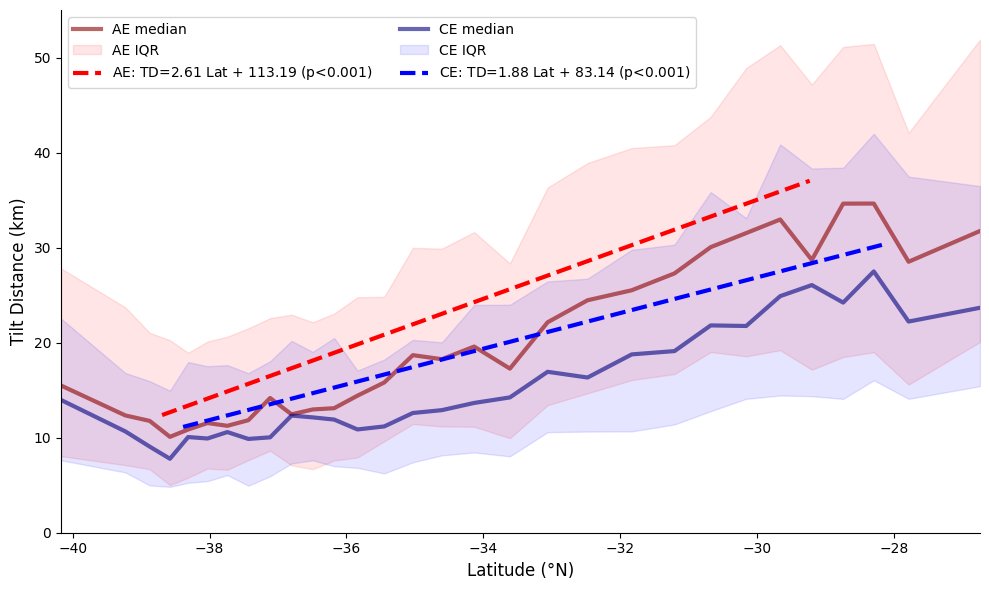

In [9]:
def panel(ax, xcol, xlabel, legend_key, xlim=None, split=None, reg_hi_override=None,
          scatter=False, xlim_flag=False, legend_flag=True, ncol=None, diff_flag=False):
    df_all = df_eddies.dropna(subset=[xcol])
    x_min, x_max = df_all[xcol].min(), df_all[xcol].max()

    nbins = 30
    bins = np.unique(np.quantile(df_all[xcol], np.linspace(0, 1, nbins + 1)))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for cyc in ['AE', 'CE']:
        dfm = df_eddies[df_eddies.Cyc == cyc].dropna(subset=[xcol, 'TiltDis'])
        
        if diff_flag:
            tilt = dfm['TiltDis'].diff().values
            xval = dfm[xcol].values
        
            nan_mask = (~np.isnan(tilt)) & (~np.isnan(xval))
            tilt = tilt[nan_mask]
            xval = xval[nan_mask]
        else:
            tilt = dfm['TiltDis'].values
            xval = dfm[xcol].values

        mask = (xval >= x_min) & (xval <= x_max)
        xval, tilt = xval[mask], tilt[mask]

        d = np.digitize(xval, bins)
        med = [np.nanmedian(tilt[d == i]) for i in range(1, len(bins))]
        q25 = [np.nanquantile(tilt[d == i], .25) for i in range(1, len(bins))]
        q75 = [np.nanquantile(tilt[d == i], .75) for i in range(1, len(bins))]

        if scatter:
            ax.scatter(xval, tilt, s=1, alpha=0.08, color=styles[cyc]['fill'])

        ax.plot(bin_centers, med, lw=3, color=styles[cyc]['line'], alpha=.6, label='' if not legend_flag else f'{cyc} median')
        ax.fill_between(bin_centers, q25, q75, color=styles[cyc]['fill'], alpha=0.10, label='' if not legend_flag else f'{cyc} IQR')

        if split is None:
            lo, hi = np.nanpercentile(xval, [10, 90])
            mask = (xval >= lo) & (xval <= hi)
            m, c, r, p, se = linregress(xval[mask], tilt[mask])
            xf = np.linspace(lo, hi, 200)
            ax.plot(
                xf, m*xf + c, '--', lw=3, color=styles[cyc]['fill'],
                label=fr'{cyc}: TD={m:.2f} {legend_key} {"$-$" if c<0 else "$+$"} {abs(c):.2f} (p{"<0.001" if p<1e-3 else f"={p:.3f}"})'
            )
            ll = m*xf + c
            print(ll[-1]-ll[0])
        else:
            lo, hi = np.nanpercentile(xval, [10, 90])
            hi2 = reg_hi_override if reg_hi_override is not None else hi

            for l, (a, b) in enumerate(zip([lo, split], [split, hi2])):
                mask = (xval >= a) & (xval <= b)
                if mask.sum() > 2:
                    m, c, r, p, se = linregress(xval[mask], tilt[mask])
                    xf = np.linspace(a, b, 200)
                    ax.plot(
                        xf, m*xf + c,
                        ':' if l == 0 else '--',
                        lw=3,
                        color=styles[cyc]['fill'],
                        label=fr'{cyc}: TD={m:.2e} {legend_key} {"$-$" if c<0 else "$+$"} {abs(c):.2f} (p{"<0.001" if p<1e-3 else f"={p:.3f}"})'
                    )

    ax.set_ylim(0, 55)
    if xlim is None:
        ax.set_xlim(*np.nanpercentile(df_eddies[xcol], [10, 90]))
    else:
        ax.set_xlim(*xlim)

    if xlim_flag:
        ax.set_xlim(bin_centers.min(), bin_centers.max())

    ax.legend(loc='upper left', ncol=ncol if ncol is not None else 2)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# ---- latitude plot using the same structure ----
fig, ax = plt.subplots(figsize=(10, 6))
styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}

panel(
    ax=ax,
    xcol='Lat',
    xlabel=r'Latitude (°N)',
    legend_key=r'Lat',
    xlim=(lat_rho.min(), lat_rho.max()),
    split=None,
    reg_hi_override=None,
    scatter=False,
    xlim_flag=True
)

ax.set_ylabel('Tilt Distance (km)', fontsize=12)
plt.tight_layout()
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Min/max tilt per bin:
2.9187645906182667 82.05694644991141
Min/max tilt per bin:
2.4605843057363956 86.61855765955914


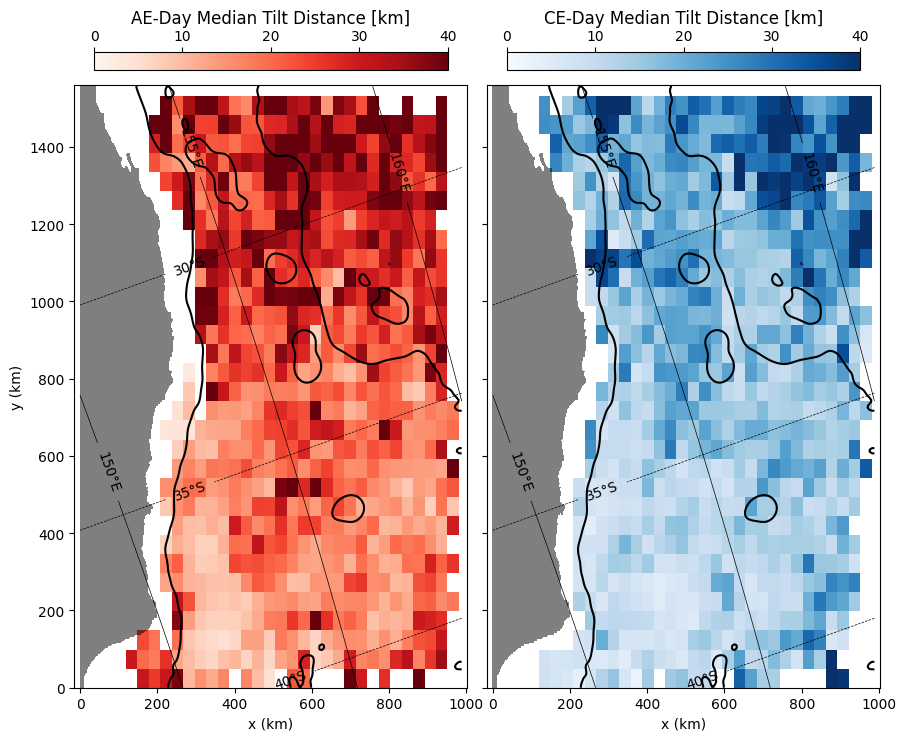

Unique Δx: [29.73256356]
Unique Δy: [49.42377476]
Number of x-bins: 30
Number of y-bins: 31


In [26]:
def _nice_step(h, base):
    s = h / base
    for k in [1, 2, 2.5, 5, 10]:
        if s <= k: 
            return k * base
    return np.ceil(s) * base

def _grid_step(G):
    gx = np.diff(np.sort(np.unique(G.ravel())))
    return np.nanmedian(gx[gx > 0])

def _bin_edges_fd(x, grid, scale=1.0, rule='fd'):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 2:
        lo, hi = np.nanmin(x), np.nanmax(x)
        return np.array([lo, hi])

    iqr = np.subtract(*np.percentile(x, [75, 25]))
    std = np.std(x, ddof=1)

    if rule.lower() == 'fd':
        bw = 2 * (iqr if iqr > 0 else 1.349 * std) / (n ** (1/3))
    else:
        bw = 3.5 * std / (n ** (1/3))

    if not np.isfinite(bw) or bw <= 0:
        rng = np.ptp(x)
        bw = rng / max(10, np.sqrt(n))

    base = _grid_step(grid)
    bw = _nice_step(scale * bw, base)

    lo = np.floor(np.nanmin(x) / bw) * bw
    hi = np.ceil(np.nanmax(x) / bw) * bw
    return np.arange(lo, hi + bw, bw)

xbins = _bin_edges_fd(df_eddies.xc.values, X_grid, scale=1.0, rule='fd')
ybins = _bin_edges_fd(df_eddies.yc.values, Y_grid, scale=1.0, rule='fd')

vmin, vmax = 0, 40
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

from matplotlib.colors import Normalize
norm = Normalize(vmin=vmin, vmax=vmax)
cmaps = {"AE-Day": "Reds", "CE-Day": "Blues"}

def binned_median(x, y, v, xbins, ybins):
    ix = np.digitize(x, xbins) - 1
    iy = np.digitize(y, ybins) - 1
    nx, ny = len(xbins) - 1, len(ybins) - 1
    ok = (ix >= 0) & (ix < nx) & (iy >= 0) & (iy < ny) & np.isfinite(v)

    ix, iy, v = ix[ok], iy[ok], v[ok]
    flat = iy * nx + ix

    hmed = np.full(nx * ny, np.nan)
    for k in np.unique(flat):
        hmed[k] = np.nanmedian(v[flat == k])

    return hmed.reshape(ny, nx)

fig, axs = plt.subplots(1, 2, figsize=(9, 8), sharey=True)

for ax, cyc in zip(axs, ['AE-Day', 'CE-Day']):
    df = df_eddies[df_eddies.Cyc == cyc[:2]].copy()
    df = df.sort_values('TiltDis', kind='mergesort', ignore_index=True)

    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    H = binned_median(df.xc.values, df.yc.values, df.TiltDis.values, xbins, ybins)
    print("Min/max tilt per bin:")
    print(np.nanmin(H), np.nanmax(H))
    m = ax.pcolormesh(xbins, ybins, H, cmap=cmaps[cyc], norm=norm,
                      shading='auto', rasterized=True)
    cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
    cb.set_label(f'{cyc} Median Tilt Distance [km]', fontsize=12)
    cb.set_ticks(np.linspace(vmin, vmax, 5))

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                    colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                    colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()

dx = np.diff(xbins)
dy = np.diff(ybins)

print("Unique Δx:", np.unique(dx))
print("Unique Δy:", np.unique(dy))
print("Number of x-bins:", len(dx))
print("Number of y-bins:", len(dy))



In [11]:
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Sample blue (from winter start) and green (from winter end)
blue  = plt.cm.winter(0.0)
green = plt.cm.winter(1.0)
cmap_bwg = LinearSegmentedColormap.from_list(
    'blue_white_green',
    [blue, 'white', green],
    N=256
)

red    = plt.cm.autumn(0.0)
yellow = plt.cm.autumn(1.0)
cmap_rwy = LinearSegmentedColormap.from_list(
    'red_white_yellow',
    [red, 'white', yellow],
    N=256
)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


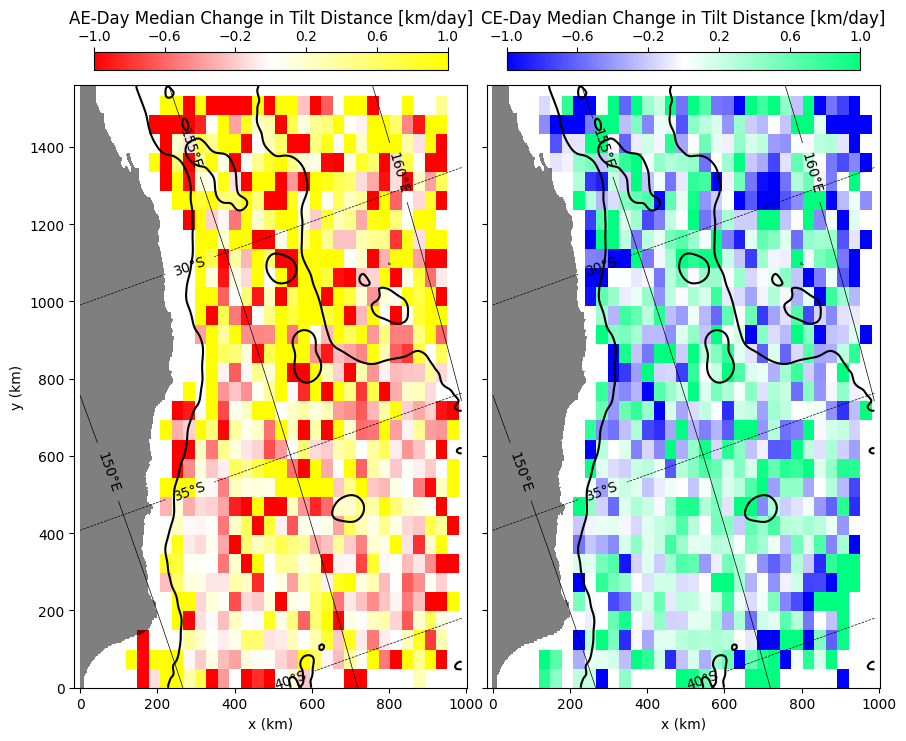

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(9, 8), sharey=True)

vmin, vmax = -1, 1
norm = Normalize(vmin=vmin, vmax=vmax)
cmaps = {"AE-Day": cmap_rwy, "CE-Day": cmap_bwg}

for ax, cyc in zip(axs, ['AE-Day', 'CE-Day']):
    df = df_eddies[df_eddies.Cyc == cyc[:2]].copy()
    df = df.sort_values('TiltDis_diff', kind='mergesort', ignore_index=True)

    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    H = binned_median(df.xc.values, df.yc.values, df.TiltDis_diff.values, xbins, ybins)
    m = ax.pcolormesh(xbins, ybins, H, cmap=cmaps[cyc], norm=norm,
                      shading='auto', rasterized=True)
    cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
    cb.set_label(f'{cyc} Median Change in Tilt Distance [km/day]', fontsize=12)
    cb.set_ticks(np.linspace(vmin, vmax, 6))

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                    colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                    colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()

dx = np.diff(xbins)
dy = np.diff(ybins)

### Time Analysis

In [13]:
# break

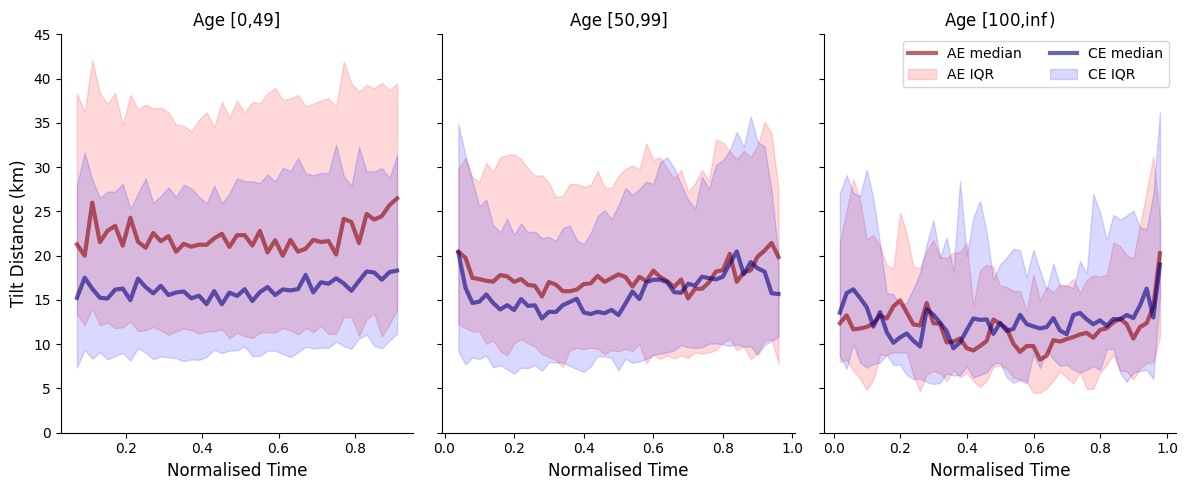

In [14]:
bin_width = 0.02

styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}

age_bins = [(0, 49), (50, 99), (100, np.inf)]
labels = ['Age [0,49]', 'Age [50,99]', r'Age [100,$\inf$)']

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

for ax, (age1, age2), title in zip(axes, age_bins, labels):

    df_sel = {}
    for cyc, df_data in zip(['AE', 'CE'], [df_AE, df_CE]):
        df_list = []
        for eddy in df_data.Eddy.unique():
            seg = df_data[df_data.Eddy == eddy]
            if (seg.Age.iloc[0] >= age1) & (seg.Age.iloc[0] <= age2):
                df_list.append(pd.DataFrame({'x': seg.norm_time, 'y': seg.TiltDis}))
        df_sel[cyc] = pd.concat(df_list, ignore_index=True).dropna() if df_list else \
                      pd.DataFrame(columns=['x','y'])

    x_arrays = [df_sel['AE'].x.values, df_sel['CE'].x.values]
    x_all = np.concatenate([arr for arr in x_arrays if len(arr)>0])
    bins = np.arange(x_all.min(), x_all.max() + bin_width, bin_width)

    for cyc in ['AE','CE']:
        df = df_sel[cyc]
        if df.empty:
            continue

        x = df.x.values
        y = df.y.values

        df['bin'] = pd.cut(df.x, bins=bins, include_lowest=True)
        grp = df.groupby('bin', observed=False)['y']
        med = grp.median()
        q25 = grp.quantile(0.25)
        q75 = grp.quantile(0.75)

        bin_centers = np.array([b.mid for b in med.index])
        m = med.notna()

        ax.plot(bin_centers[m], med[m], lw=3, color=styles[cyc]['line'], alpha=0.6, label=f'{cyc} median')
        ax.fill_between(bin_centers[m], q25[m], q75[m], color=styles[cyc]['fill'], alpha=0.15, label=f'{cyc} IQR')

        slope, intercept, r, p, err = linregress(x, y)
        xl = np.linspace(x.min(), x.max(), 200)
        yl = slope * xl + intercept
        # Uncomment if you'd like regression lines
        # ax.plot(xl, yl, '--', lw=3, color=styles[cyc]['fill'], alpha=0.6)

    ax.set_title(title)
    ax.set_ylim(0, 45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Normalised Time', fontsize=12)

axes[2].legend(loc='upper right', ncol=2)
axes[0].set_ylabel('Tilt Distance (km)', fontsize=12)
plt.tight_layout()
plt.show()







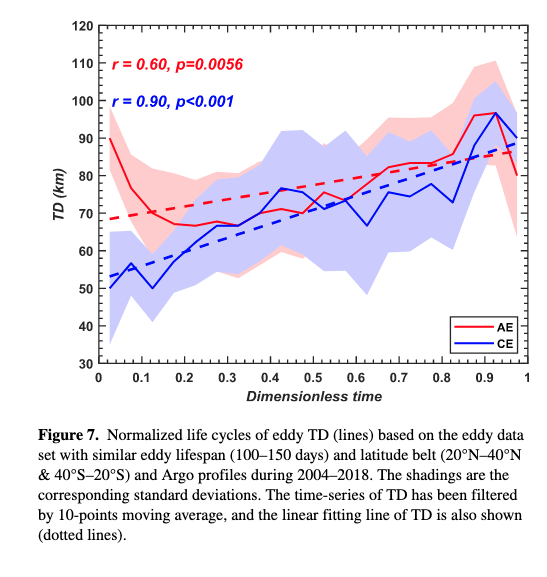

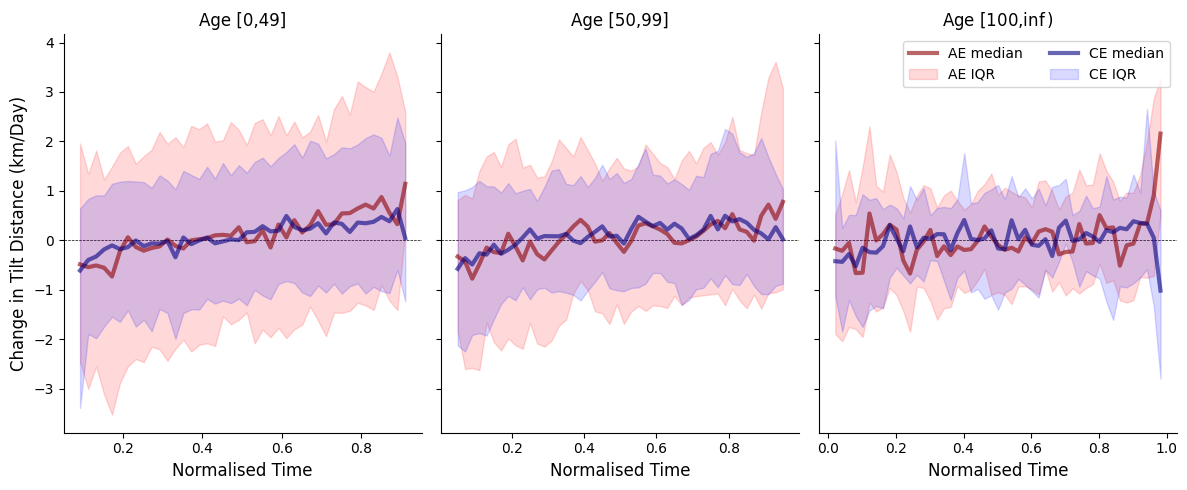

In [15]:
bin_width = 0.02

styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}

age_bins = [(0, 49), (50, 99), (100, np.inf)]
labels = ['Age [0,49]', 'Age [50,99]', r'Age [100,$\inf$)']

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

for ax, (age1, age2), title in zip(axes, age_bins, labels):

    df_sel = {}
    for cyc, df_data in zip(['AE', 'CE'], [df_AE, df_CE]):
        df_list = []
        for eddy in df_data.Eddy.unique():
            seg = df_data[df_data.Eddy == eddy]
            if (seg.Age.iloc[0] >= age1) & (seg.Age.iloc[0] <= age2):
                df_list.append(pd.DataFrame({'x': seg.norm_time, 'y': seg.TiltDis_diff}))
        df_sel[cyc] = pd.concat(df_list, ignore_index=True).dropna() if df_list else \
                      pd.DataFrame(columns=['x','y'])

    x_arrays = [df_sel['AE'].x.values, df_sel['CE'].x.values]
    x_all = np.concatenate([arr for arr in x_arrays if len(arr)>0])
    bins = np.arange(x_all.min(), x_all.max() + bin_width, bin_width)

    for cyc in ['AE','CE']:
        df = df_sel[cyc]
        if df.empty:
            continue

        x = df.x.values
        y = df.y.values

        df['bin'] = pd.cut(df.x, bins=bins, include_lowest=True)
        grp = df.groupby('bin', observed=False)['y']
        med = grp.median()
        q25 = grp.quantile(0.25)
        q75 = grp.quantile(0.75)

        bin_centers = np.array([b.mid for b in med.index])
        m = med.notna()

        ax.plot(bin_centers[m], med[m], lw=3, color=styles[cyc]['line'], alpha=0.6, label=f'{cyc} median')
        ax.fill_between(bin_centers[m], q25[m], q75[m], color=styles[cyc]['fill'], alpha=0.15, label=f'{cyc} IQR')

        slope, intercept, r, p, err = linregress(x, y)
        xl = np.linspace(x.min(), x.max(), 200)
        yl = slope * xl + intercept
        # Uncomment if you'd like regression lines
        # ax.plot(xl, yl, '--', lw=3, color=styles[cyc]['fill'], alpha=0.6)

    ax.set_title(title)
    # ax.set_ylim(0, 45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Normalised Time', fontsize=12)
    ax.axhline(0, lw=.5, ls='--', color='k', zorder=-1)

axes[2].legend(loc='upper right', ncol=2)
axes[0].set_ylabel('Change in Tilt Distance (km/Day)', fontsize=12)
plt.tight_layout()
plt.show()

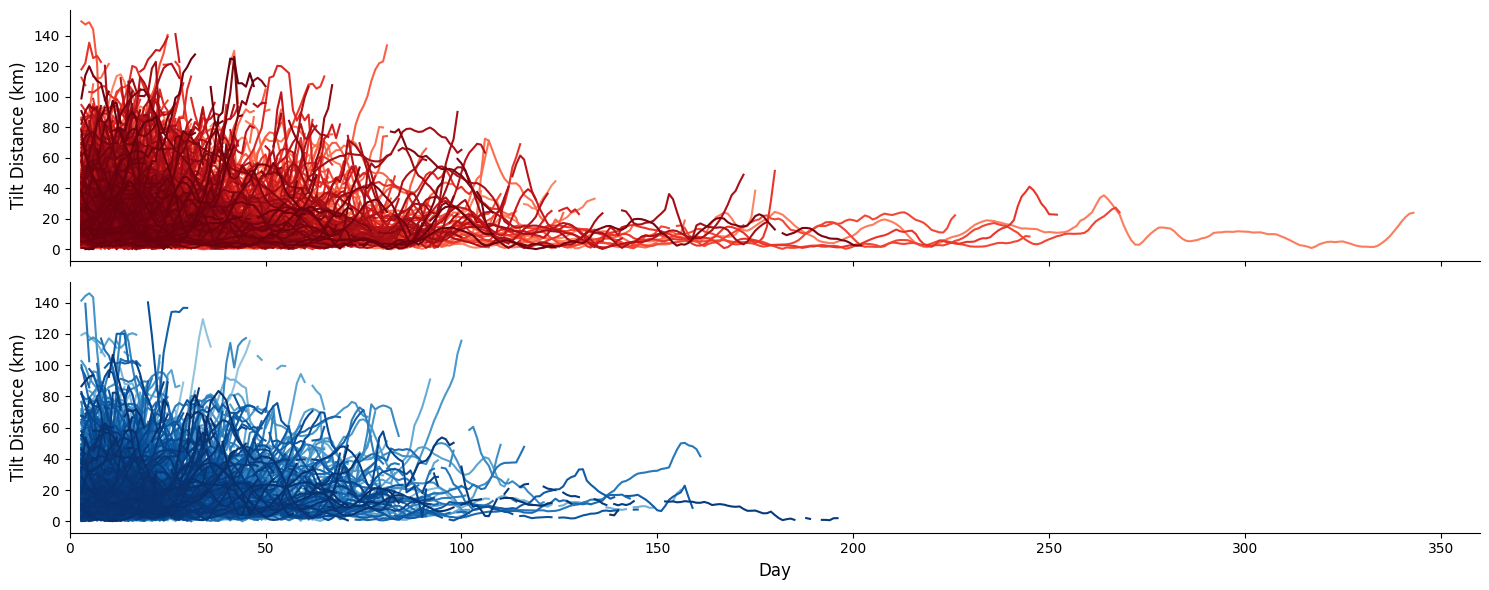

In [16]:
import matplotlib.cm as cm

ae = df_eddies[df_eddies.Cyc == 'AE'].Eddy.unique()
ce = df_eddies[df_eddies.Cyc == 'CE'].Eddy.unique()
# colour ranges
colors_ae = cm.Reds(np.linspace(0.4, 1, len(ae)))
colors_ce = cm.Blues(np.linspace(0.4, 1, len(ce)))

fig, axs = plt.subplots(2, 1, figsize=(15,6), sharex=True)
ae_idx, ce_idx = 0, 0
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    if df.Cyc.iloc[0] == 'AE':
        axs[0].plot(np.arange(len(df)), df.TiltDis, color=colors_ae[ae_idx])
        # axs[0].set_xlabel('Day', fontsize=12)
        axs[0].set_ylabel('Tilt Distance (km)', fontsize=12)
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        ae_idx += 1
    else:
        axs[1].plot(np.arange(len(df)), df.TiltDis, color=colors_ce[ce_idx])
        axs[1].set_xlabel('Day', fontsize=12)
        axs[1].set_ylabel('Tilt Distance (km)', fontsize=12)
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['right'].set_visible(False)
        ce_idx += 1
axs[0].set_xlim(0, None); axs[1].set_xlim(0, None)
plt.tight_layout()


### Seasonality



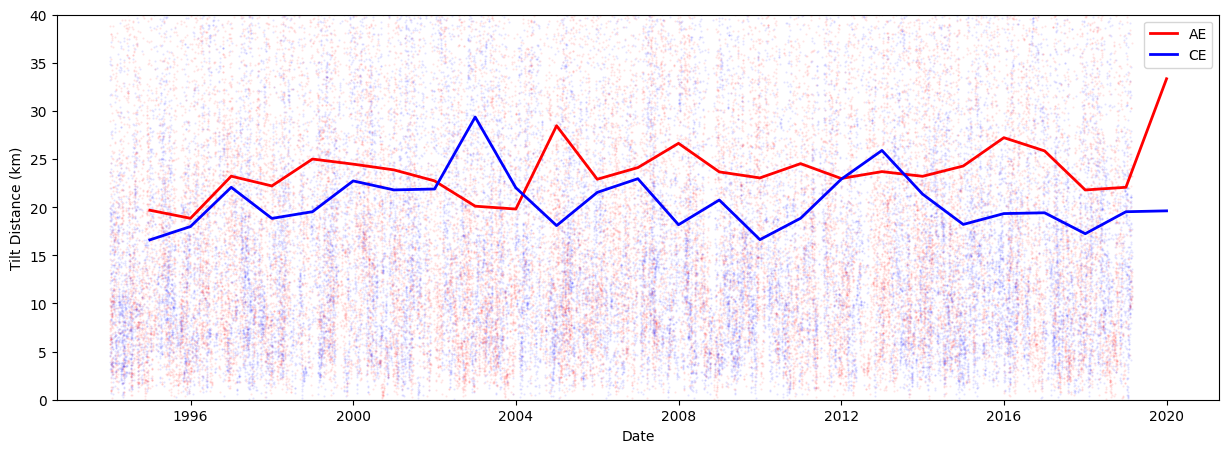

In [17]:
plt.figure(figsize=(15,5))

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    # mean = df.groupby(pd.Grouper(key='Date', freq='6MS')).TiltDis.mean()
    mean = df.groupby(pd.Grouper(key='Date', freq='1YE')).TiltDis.mean()
    plt.scatter(df.Date, df.TiltDis, s=1, alpha=0.1, color=c, marker='.')
    plt.plot(mean.index, mean.values, lw=2, color=c, label=label)

plt.xlabel('Date'); plt.legend()
plt.ylabel('Tilt Distance (km)')
plt.ylim(0, 40)
plt.show()


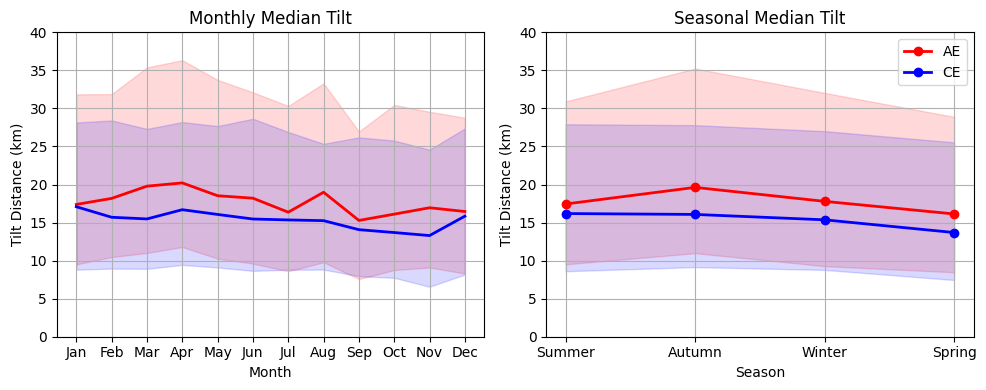

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# -------------------
# 1) MONTHLY PANEL
# -------------------
ax = axs[0]

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Month'] = df_.Date.dt.month

    g = df_.groupby('Month').TiltDis
    med = g.median()
    q25 = g.quantile(0.25)
    q75 = g.quantile(0.75)

    ax.plot(med.index, med.values, lw=2, color=c, label=label)
    ax.fill_between(med.index, q25, q75, color=c, alpha=0.15)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('Month')
ax.set_ylabel('Tilt Distance (km)')
ax.set_ylim(0, 40)
ax.set_title('Monthly Median Tilt')
ax.grid(True)

# -------------------
# 2) SEASONAL PANEL
# -------------------
ax = axs[1]

season_map = {
    12:'Summer',1:'Summer',2:'Summer',
    3:'Autumn',4:'Autumn',5:'Autumn',
    6:'Winter',7:'Winter',8:'Winter',
    9:'Spring',10:'Spring',11:'Spring'
}
season_order = ['Summer','Autumn','Winter','Spring']

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Season'] = df_['Date'].dt.month.map(season_map)
    df_['Season'] = pd.Categorical(df_['Season'], categories=season_order, ordered=True)

    g = df_.groupby('Season', observed=True).TiltDis
    med = g.median().reindex(season_order)
    q25 = g.quantile(0.25).reindex(season_order)
    q75 = g.quantile(0.75).reindex(season_order)

    x = np.arange(len(season_order))
    ax.plot(x, med.values, lw=2, marker='o', color=c, label=label)
    ax.fill_between(x, q25, q75, color=c, alpha=0.15)

ax.set_xticks(x)
ax.set_xticklabels(season_order)
ax.set_xlabel('Season')
ax.set_ylabel('Tilt Distance (km)')
ax.set_ylim(0, 40)
ax.set_title('Seasonal Median Tilt')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


Could hypothesis that warmer waters = more stratified water = more tilt

<function matplotlib.pyplot.show(close=None, block=None)>

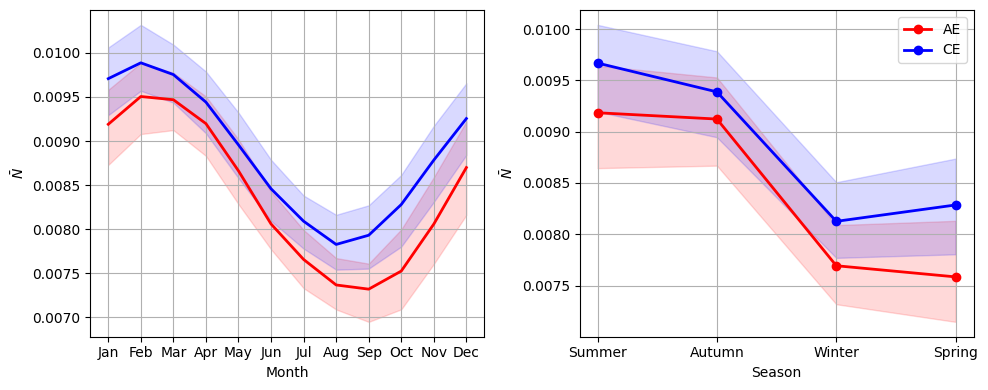

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# -------------------
# 1) MONTHLY PANEL
# -------------------
ax = axs[0]

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Month'] = df_.Date.dt.month

    g = df_.groupby('Month').Nbar
    med = g.median()
    q25 = g.quantile(0.25)
    q75 = g.quantile(0.75)

    ax.plot(med.index, med.values, lw=2, color=c, label=label)
    ax.fill_between(med.index, q25, q75, color=c, alpha=0.15)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('Month')
ax.set_ylabel(r'$\bar{N}$')
# ax.set_ylim(0, 40)
# ax.set_title('Monthly Median Tilt')
ax.grid(True)

# -------------------
# 2) SEASONAL PANEL
# -------------------
ax = axs[1]

season_map = {
    12:'Summer',1:'Summer',2:'Summer',
    3:'Autumn',4:'Autumn',5:'Autumn',
    6:'Winter',7:'Winter',8:'Winter',
    9:'Spring',10:'Spring',11:'Spring'
}
season_order = ['Summer','Autumn','Winter','Spring']

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Season'] = df_['Date'].dt.month.map(season_map)
    df_['Season'] = pd.Categorical(df_['Season'], categories=season_order, ordered=True)

    g = df_.groupby('Season', observed=True).Nbar
    med = g.median().reindex(season_order)
    q25 = g.quantile(0.25).reindex(season_order)
    q75 = g.quantile(0.75).reindex(season_order)

    x = np.arange(len(season_order))
    ax.plot(x, med.values, lw=2, marker='o', color=c, label=label)
    ax.fill_between(x, q25, q75, color=c, alpha=0.15)

ax.set_xticks(x)
ax.set_xticklabels(season_order)
ax.set_xlabel('Season')
ax.set_ylabel(r'$\bar{N}$')
# ax.set_ylim(0, 40)
# ax.set_title('Seasonal Median Tilt')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show


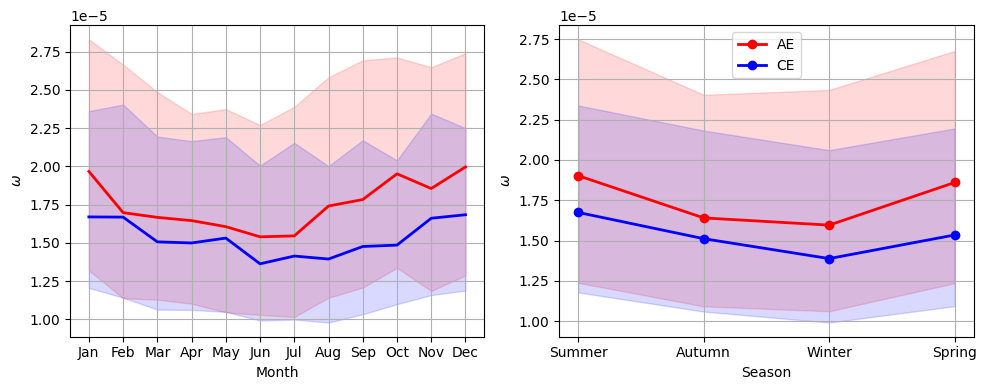

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# -------------------
# 1) MONTHLY PANEL
# -------------------
ax = axs[0]

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Month'] = df_.Date.dt.month

    g = df_.groupby('Month').w
    med = np.abs(g.median())
    q25 = np.abs(g.quantile(0.25))
    q75 = np.abs(g.quantile(0.75))

    ax.plot(med.index, med.values, lw=2, color=c, label=label)
    ax.fill_between(med.index, q25, q75, color=c, alpha=0.15)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('Month')
ax.set_ylabel(r'$\omega$')
# ax.set_ylim(0, 40)
# ax.set_title('Monthly Median Tilt')
ax.grid(True)

# -------------------
# 2) SEASONAL PANEL
# -------------------
ax = axs[1]

season_map = {
    12:'Summer',1:'Summer',2:'Summer',
    3:'Autumn',4:'Autumn',5:'Autumn',
    6:'Winter',7:'Winter',8:'Winter',
    9:'Spring',10:'Spring',11:'Spring'
}
season_order = ['Summer','Autumn','Winter','Spring']

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Season'] = df_['Date'].dt.month.map(season_map)
    df_['Season'] = pd.Categorical(df_['Season'], categories=season_order, ordered=True)

    g = df_.groupby('Season', observed=True).w
    med = np.abs(g.median().reindex(season_order))
    q25 = np.abs(g.quantile(0.25).reindex(season_order))
    q75 = np.abs(g.quantile(0.75).reindex(season_order))

    x = np.arange(len(season_order))
    ax.plot(x, med.values, lw=2, marker='o', color=c, label=label)
    ax.fill_between(x, q25, q75, color=c, alpha=0.15)

ax.set_xticks(x)
ax.set_xticklabels(season_order)
ax.set_xlabel('Season')
ax.set_ylabel(r'$\omega$')
# ax.set_ylim(0, 40)
# ax.set_title('Seasonal Median Tilt')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()



### Temperature

### Eddy Propogation

In [21]:
# kmday_to_ms = 1000 / 86400

# # --- top-centre displacements + propagation speed ---
# df_eddies['dx_top'] = df_eddies.groupby('Eddy')['xc'].diff()
# df_eddies['dy_top'] = df_eddies.groupby('Eddy')['yc'].diff()
# df_eddies['EddyProp'] = np.hypot(df_eddies['dx_top'], df_eddies['dy_top']) * kmday_to_ms

# # --- bottom-centre positions (single pass) ---
# df_idx = df_eddies.set_index(['Eddy', 'Day'])

# x_btm, y_btm = [], []
# for eddy, dic in dic_eddies_vert.items():
#     eddy_id = int(eddy[4:])  # "Eddy####" -> ####
#     for day, df in dic.items():
#         day_id = int(day[3:])  # "Day##" -> ##
#         if len(df):
#             d = df[df.Depth.abs() < 1000]
#             row = (d.iloc[-1] if len(d) else df.iloc[-1])
#             x_btm.append(row.x)
#             y_btm.append(row.y)
#         else:
#             row = df_idx.loc[(eddy_id, day_id)]
#             x_btm.append(row.xc)
#             y_btm.append(row.yc)

# df_eddies['x_btm'] = x_btm
# df_eddies['y_btm'] = y_btm

# # --- bottom-centre displacements + propagation speed ---
# df_eddies['dx_btm'] = df_eddies.groupby('Eddy')['x_btm'].diff()
# df_eddies['dy_btm'] = df_eddies.groupby('Eddy')['y_btm'].diff()
# df_eddies['btm_prop'] = np.hypot(df_eddies['dx_btm'], df_eddies['dy_btm']) * kmday_to_ms

# # --- separation and separation rate ---
# df_eddies['sep_km'] = np.hypot(df_eddies['x_btm'] - df_eddies['xc'],
#                                df_eddies['y_btm'] - df_eddies['yc'])
# df_eddies['sep_rate_ms'] = df_eddies.groupby('Eddy')['sep_km'].diff() * kmday_to_ms

# # --- optional: vector difference between top and bottom (m/s) ---
# df_eddies['top_btm_diff'] = np.hypot(df_eddies['dx_btm'] - df_eddies['dx_top'],
#                                      df_eddies['dy_btm'] - df_eddies['dy_top']) * kmday_to_ms


In [22]:
# fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True, sharey=False)

# panel(
#     ax=axs[0,0],
#     xcol='EddyProp',
#     xlabel=r'Surface Propagation Speed (ms$^{-1}$)',
#     legend_key=r'$x$',
#     split=None,
#     reg_hi_override=None,
#     scatter=False,
#     xlim_flag=True,
#     legend_flag=False,
#     ncol=1
# )
# axs[0,0].set_ylabel('Tilt Distance (km)', fontsize=12)
# axs[0,0].set_xlim(0, .8)
# # axs[0,0].set_ylim(0, 50)

# panel(
#     ax=axs[0,1],
#     xcol='btm_prop',
#     xlabel=r'Bottom Propagation Speed (ms$^{-1}$)',
#     legend_key=r'$x$',
#     split=None,
#     reg_hi_override=None,
#     scatter=False,
#     xlim_flag=True,
#     legend_flag=False,
#     ncol=1
# )
# axs[0,1].set_xlim(0, .8)
# # axs[0,1].set_ylim(0, 50)

# gs = axs[1,0].get_gridspec()
# axs[1,0].remove()
# axs[1,1].remove()
# ax_big = fig.add_subplot(gs[1, :])

# panel(
#     ax=ax_big,
#     xcol='sep_rate_ms',
#     xlabel=r'Top and Bottom Separation Rate (ms$^{-1}$)',
#     legend_key=r'$x$',
#     split=None,
#     reg_hi_override=None,
#     scatter=False,
#     xlim_flag=True,
#     legend_flag=False,
#     diff_flag=True,
#     ncol=2
# )
# ax_big.set_xlim(-.4, .4)
# ax_big.set_ylim(-2, 2)
# ax_big.axhline(0, lw=.5, color='k', zorder=-1, ls='--')
# ax_big.set_ylabel('Change in Tilt Distance (km)', fontsize=12)

# axs[0, 0].text(-0.1, 1.15, 'a)', transform=axs[0, 0].transAxes,
#                fontsize=12, fontweight='bold', va='top', ha='left')
# axs[0, 1].text(-0.1, 1.15, 'b)', transform=axs[0, 1].transAxes,
#                fontsize=12, fontweight='bold', va='top', ha='left')
# ax_big.text(-0.05, 1.15, 'c)', transform=ax_big.transAxes,
#             fontsize=12, fontweight='bold', va='top', ha='left')

# plt.show()


In [23]:
# # ---- latitude plot using the same structure ----
# fig, axs = plt.subplots(1,3, figsize=(14, 4), constrained_layout=True, sharey=True)
# styles = {
#     'AE': {'line': 'darkred', 'fill': 'red'},
#     'CE': {'line': 'navy',    'fill': 'blue'}
# }

# panel(
#     ax=axs[0],
#     xcol='EddyProp',
#     xlabel=r'Surface Propagation Speed (ms$^{-1}$)',
#     legend_key=r'$x$',
#     # xlim=(0, .4),
#     split=None,
#     reg_hi_override=None,
#     scatter=False,
#     xlim_flag=True,
#     legend_flag=False,
#     ncol=1
# )
# axs[0].set_ylabel('Tilt Distance (km)', fontsize=12)
# axs[0].set_xlim(0, .8)

# panel(
#     ax=axs[1],
#     xcol='btm_prop',
#     xlabel=r'Bottom Propagation Speed (ms$^{-1}$)',
#     legend_key=r'$x$',
#     # xlim=(lat_rho.min(), lat_rho.max()),
#     split=None,
#     reg_hi_override=None,
#     scatter=False,
#     xlim_flag=True,
#     legend_flag=False,
#     ncol=1
# )
# axs[1].set_xlim(0, .8)
# # axs[1].set_ylabel('Tilt Distance (km)', fontsize=12)

# panel(
#     ax=axs[2],
#     xcol='top_btm_diff',
#     xlabel = r'$||\mathbf{v}_\text{top}-\mathbf{v}_\text{btm}||$ (ms$^{-1}$)',
#     legend_key=r'$x$',
#     # xlim=(lat_rho.min(), lat_rho.max()),
#     split=None,
#     reg_hi_override=None,
#     scatter=False,
#     xlim_flag=True,
#     legend_flag=False,
#     ncol=1
# )
# axs[2].set_xlim(0, .8)
# # axs[2].set_ylabel('Tilt Distance (km)', fontsize=12)

# plt.show()


### Breaking it up top 300m and below 300m

In [24]:
path = "/srv/scratch/z5297792/Climatology/N2s/N2_ave.npy"
N2_ave = np.load(path)


In [25]:
top_btm_thresh = 300
mask_top = np.abs(z_r) <= top_btm_thresh
mask_btm = (np.abs(z_r) >= top_btm_thresh) & (np.abs(z_r) <= 1000)

# Stratification
N2_top_ave = np.nanmean(N2_ave[mask_top])
N2_btm_ave = np.nanmean(N2_ave[mask_btm])

print(f'Strafication:')
print(f'Top={N2_top_ave:.2e}')
print(f'Btm={N2_btm_ave:.2e}')
print('')

# Background Flow
u_ave = np.load('/srv/scratch/z5297792/Climatology/u_ave.npy')
v_ave = np.load('/srv/scratch/z5297792/Climatology/v_ave.npy')
u_ave = np.where(mask_rho[:, :, None], u_ave, np.nan)
v_ave = np.where(mask_rho[:, :, None], v_ave, np.nan)
S = np.hypot(u_ave, v_ave)
S_top_ave = np.nanmean(S[mask_top])
S_btm_ave = np.nanmean(S[mask_btm])

print(f'Flow:')
print(f'Top={S_top_ave:.2f} m/s')
print(f'Btm={S_btm_ave:.2f} m/s')
print('')

Strafication:
Top=8.29e-05
Btm=5.58e-05

Flow:
Top=0.12 m/s
Btm=0.04 m/s

